# Laboratory Experiment 007: Rectangular Window
# Marvin D. Llames
# BSCPE 3-1-2025-2026

How do we design Window functions to obtain higher stopband attenuation? There are 2 versions, for windows of **even** and **odd length**. We now analyse a few common window types.

Lets start again with the **rectangular window**.
$h(n)=1$, for n=0,...,L-1.<br>

In Python we get its frequency response for L=16:

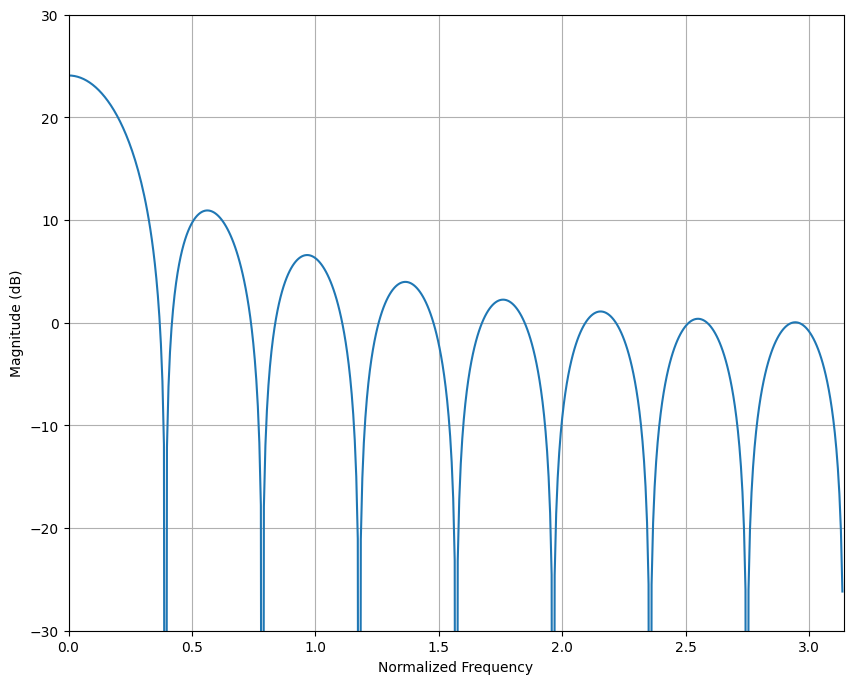

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

h=np.ones(16);
omega, H =signal.freqz(h)
plt.figure(figsize=(10,8))
plt.plot(omega, 20*np.log10(abs(H)+1e-6))
plt.axis([0, 3.14, -30, 30])
plt.xlabel('Normalized Frequency')
plt.ylabel('Magnitude (dB)')
plt.grid()

Observe: Its main lobe has a 3dB width of about $0.05 \pi \approx 0.16$, the side lobe attenuation is about -15 to -25 dB.<br>
We can design different windows, which de-emphasize a transition region from passband to stopband, and emphasize the stopband attenuation more than the passband attenuation.

This can be seen as minimizing a **weighted** squared error function, where the parts the we want to emphasize get a higher weight.

In Python we can formulate an error function with a weighted squared error as follows, with pb, tb: number of frequency samples in the passband and transitionband, respectively,

In [2]:
import numpy as np
import scipy.signal as signal

def errfunc(h):
    numfreqsamples=512

    #desired passband:
    pb=int(numfreqsamples/4.0)
    #desired transition band:
    tb=int(numfreqsamples/8.0)

    w, H = signal.freqz(h,1,numfreqsamples)
    H_desired=np.concatenate((np.ones(pb),np.zeros(numfreqsamples-pb)))
    weights = np.concatenate((np.ones(pb),np.zeros(tb), 1000*np.ones(numfreqsamples-pb-tb)))
    err = np.sum(np.abs(H-H_desired)*weights)
    return err

#### View H Desired and Weights

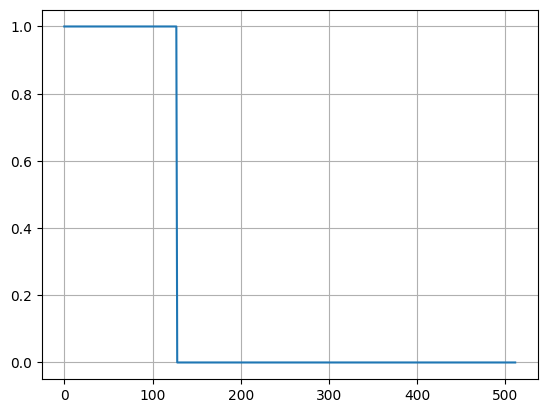

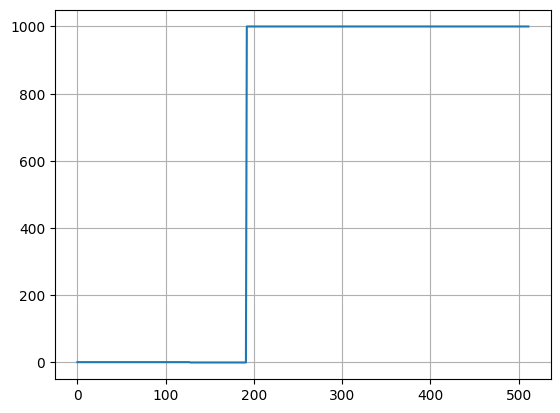

In [3]:
import matplotlib.pyplot as plt
import numpy as np

numfreqsamples=512

#desired passband:
pb=int(numfreqsamples/4.0)
#desired transition band:
tb=int(numfreqsamples/8.0)

# See H_Desired
plt.figure()
plt.plot(np.concatenate((np.ones(pb),np.zeros(numfreqsamples-pb))))
plt.grid()

plt.figure()
plt.plot(np.concatenate((np.ones(pb),np.zeros(tb), 1000*np.ones(numfreqsamples-pb-tb))))
plt.grid()

We can then apply optimization to obtain the window or filter samples which minimize this error, for instance using “scipy.optimize”. In this example a window or filter h (depending on how it is used) of length 16 samples or taps is obtained with:

In [4]:
import scipy.optimize as opt

x0=np.random.rand(16) #alternative: e.g. 32
print('x0=', x0)
minout=opt.minimize(errfunc,x0)
h=minout.x
print('h=', h)

x0= [0.94328204 0.11602224 0.45141806 0.86935342 0.02591587 0.93923464
 0.54059071 0.68243609 0.52823807 0.0286177  0.70123942 0.1047498
 0.40927229 0.44731263 0.60502895 0.24122482]
h= [-0.00030484 -0.00171093 -0.00530408 -0.01217898 -0.02251219 -0.03495054
 -0.0467492  -0.05456794 -0.05588673 -0.05024726 -0.03946759 -0.02669659
 -0.01522518 -0.0070338  -0.00239559 -0.00046466]


We get the samples or impulse response as:

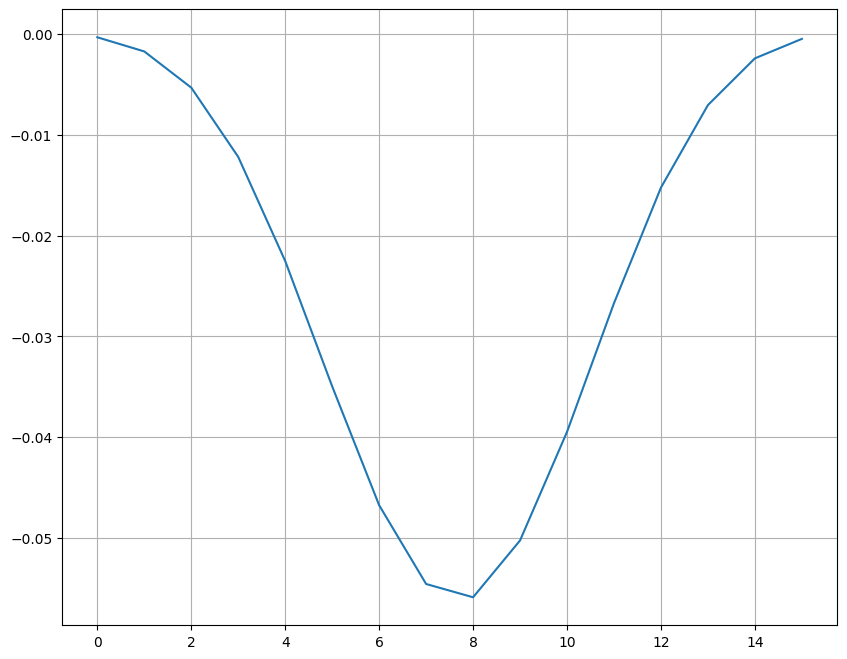

In [5]:
plt.figure(figsize=(10,8))
plt.plot(h)
plt.grid()

**Observe:** the negative sign doesn’t matter, because we only optimized for the magnitude. It magnitude of the frequency response is,

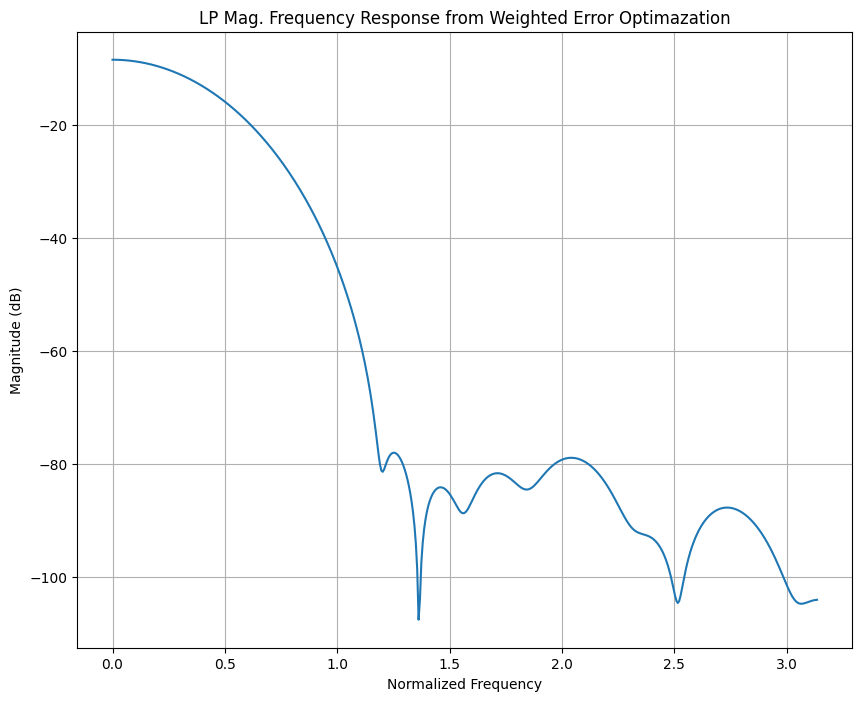

In [6]:
omega, H =signal.freqz(h)
plt.figure(figsize=(10,8))
plt.plot(omega, 20*np.log10(abs(H)+1e-6))
plt.xlabel('Normalized Frequency')
plt.ylabel('Magnitude (dB)')
plt.title('LP Mag. Frequency Response from Weighted Error Optimazation')
plt.grid()

Observe the decently high stopband attenuation of about -80 dB!

Usually this optimization gives the best answer for most applications. But there are also more **“pre-fabricated” windows** for filter design, with different trade-offs of transition band width and stopband attenuation, for convenience.

# Hanning Window

The first is the **raised cosine window**, also known as **Hann- or Hanning Window**:

$$\large
 {h ( n ) =0.5 - 0.5cos \left(  \frac{  2π}   {L}   ( n+0. 5 )  \right) }
$$
,with n=0,…,L-1, for even window lengths.

An example of a raised cosine with even window length and L=16:  We obtain its plot with:


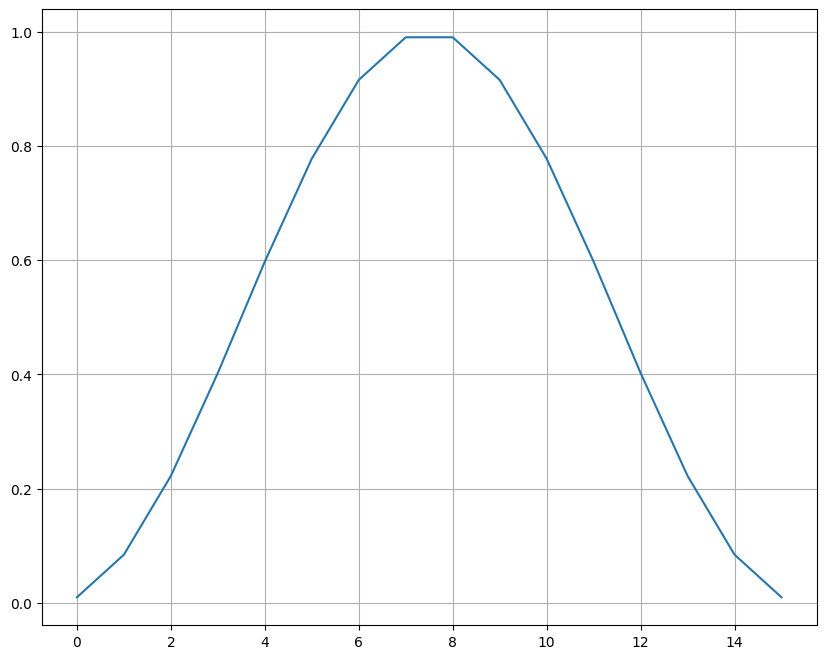

In [7]:
h=0.5-0.5*np.cos(2*np.pi/16*(np.arange(16)+0.5))

plt.figure(figsize=(10,8))
plt.plot(h)
plt.grid()

**Observe:** The center is between 2 samples!

Its frequency response is obtained with freqz:


In [8]:
def freqz(x):
    # get frequency bins and according magnitude values
    f, H = signal.freqz(x)

    #normalized frequency
    fNorm = f/np.pi

    # magnitude in dB
    hdB = 20 * np.log10(abs(H)+1e-5) #"+1e-5" avoids log10(0)!

    # open figure
    plt.figure(figsize=(10,8))

    plt.subplot(211)
    plt.title('Magnitude')
    plt.plot(f, hdB, 'b')
    plt.axis([0,3.14,np.min(hdB)-1,np.max(hdB)+1])
    plt.grid(True)
    plt.xlabel('Normalized Frequency (rad/sample)')
    plt.ylabel('Magnitude (dB)')

    plt.subplot(212)
    plt.title('Phase')
    angles = np.unwrap(np.angle(H))
    anglesGrad = (360 * angles)/(2*np.pi)
    plt.plot(f, anglesGrad, 'b')
    plt.axis([0,3.14,np.min(anglesGrad),np.max(anglesGrad)])
    plt.grid(True)
    plt.xlabel('Normalized Frequency (rad/sample)')
    plt.ylabel('Phase (degrees)')
    plt.tight_layout()

In [ ]:
freqz(h)

Here we can see that we obtain also a much higher attenuation (in comparison to the rectangular function) for the first side lobe, at over -35 dB (measured from the maximum of the main lobe, the pass band), and far off in the stop band we get about -60 dB attenuation!

But at the cost of a wider main lobe (its 3dB width is about $0.1\pi$, twice as wide as for the rectangular window), which leads to a wider transition band.

This shows a **general trade-off:** We can **trade transition width** for **stop-band attenuation.**

For odd window lengths we get:

$$\large
h(n)=0.5-0.5cos \left(\frac{2\pi}{L+1}(n+1)\right)$$
, with n=0,…,L-1.

Example for L=17 (number of samples of the impulse response, equal to the coefficients, since this represents an FIR filter):


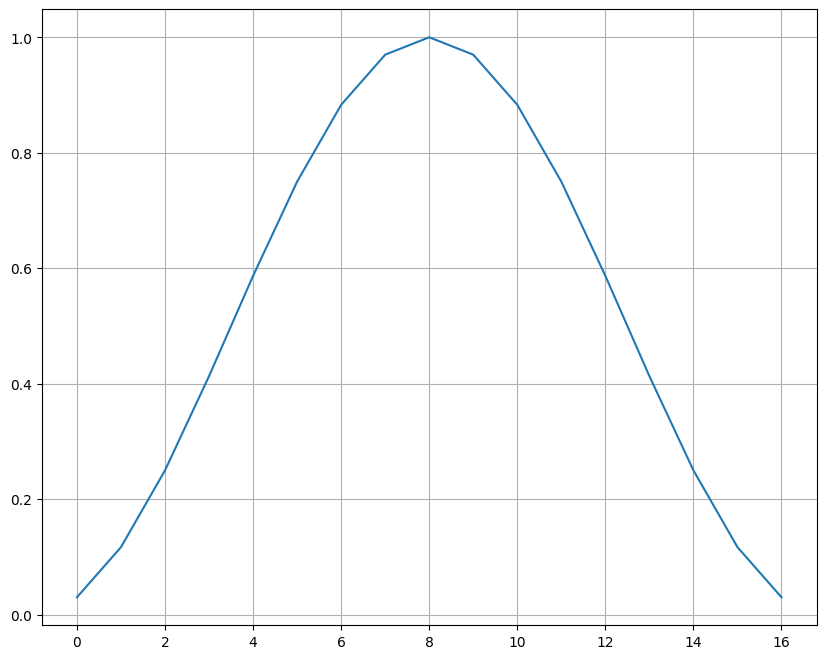

In [9]:
h=0.5-0.5*np.cos(2*np.pi/18*(np.arange(17)+1))

plt.figure(figsize=(10,8))
plt.plot(h)
plt.grid()

**Observe:** Here the center is right on one sample!

For the **Sine window** we get:

$$\large
h(n)=sin(\frac{\pi}{L}(n+0.5))$$

,with n=0,…,L-1 for even window lengths L, or

$$\large
h(n)=sin(\frac{\pi}{L+1}(n+1))
$$
,with n=0,…,L-1 for odd window length L.

Example for L=16:

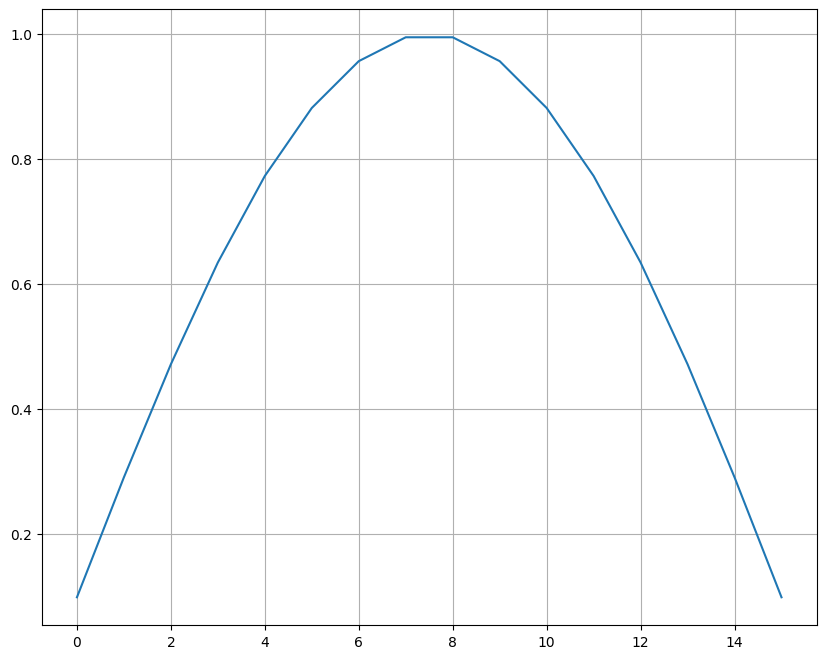

In [10]:
s=np.sin(np.pi/16*(np.arange(16)+0.5))

plt.figure(figsize=(10,8))
plt.plot(s)
plt.grid()

Its frequency response is:

In [ ]:
freqz(s)

Here we can see that the **main lobe is somewhat narrower** than for the raised cosine window, with a 3dB width of about $0.04\pi$, but the first side lobe has only about -20 dB attenuation. But the further side lobes increase in attenuation. This **attenuation** is more  than for the rectangular window, but **less than for the raised cosine window**. On the other hand, its transition bandwidth is less than for the raised cosine window.

Observe that this always results in positive values for the window functions, and that they are perfectly symmetric (for odd lengths there is a sample right at the center, for even length windows the center is right between 2 center samples).